In [1]:
import pandas as pd
import numpy as np
import re
from random import random
import emoji
from tqdm import notebook
def tqdm(x, **kargs):
    return notebook.tqdm(x, leave=False, **kargs)
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import torch
from torch.nn import BCEWithLogitsLoss, MultiLabelMarginLoss
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [2]:
from simpletransformers.classification import MultiLabelClassificationModel, ClassificationModel
from sklearn.preprocessing import MultiLabelBinarizer

I0530 04:51:39.595855 140190413342528 file_utils.py:39] PyTorch version 1.5.0 available.


## Read input data

In [3]:
df = pd.read_json('./source/train_gold.json', lines=True)
df_new = df.copy()
df_new.head()

,idx,text,reply,categories,mp4
0,0,we can all agree that any song by Niall Horan.,oui oui,[yes],6dc39e96b11275f064fdaed88273b45e.mp4
1,1,Will you be installing #ScottyFromMarketing's ...,,[no],cfff051f05d8d3b7136c7d58ea6ad55f.mp4
2,2,Growing up my mum would call me a Nigga despit...,And he joins in??? Pour some hot grits on em,[smh],bf39e7bd9ad24354ce3ba6822b0104af.mp4
3,3,Rest your head on my chest when the world feel...,😂😂😂😂😂,[wink],173a707a04c277354a2f23cf01d6151e.mp4
4,4,Imagine Will Hernandez and Wills both doing a ...,,[yes],aab6d6bfb0c1382269ddba9b71cc8b7a.mp4


In [4]:
categories_type = pd.read_json('./source/categories.json', lines=True)
categories_mapping = {v[0]: k for k, v in categories_type.to_dict('list').items()}

In [5]:
df_dev = pd.read_json('./source/dev_unlabeled.json', lines=True)
df_dev_result = df_dev.copy()[['text', 'reply']]
df_dev_result.head()

,text,reply
0,"Drop your cash app, use hashtag #BailoutHumansNow",$tyratomaro #BailoutHumans
1,After interviewing with a few incredible peopl...,CONGRATS!!!!!
2,I know GTC festival not happening next month b...,
3,"Lordy, my daughter just said, “I wonder how th...",
4,THE UNEMPLOYMENT CLAIM SYSTEM SUCKS SO MUCH DICK,Watching everyone else get their weekly unempl...


## Data cleaning and preprocessing

In [6]:
# https://github.com/minerva-ml/open-solution-toxic-comments/blob/master/external_data/apostrophes.json
apostrophes = {
  "arent": "are not",
  "cant": "cannot",
  "couldnt": "could not",
  "didnt": "did not",
  "doesnt": "does not",
  "dont": "do not",
  "hadnt": "had not",
  "hasnt": "has not",
  "havent": "have not",
  "hed": "he would",
  "hell": "he will",
  "hes": "he is",
  "id": "I had",
  "ill": "I will",
  "im": "I am",
  "isnt": "is not",
  "its": "it is",
  "itll": "it will",
  "ive": "I have",
  "lets": "let us",
  "mightnt": "might not",
  "mustnt": "must not",
  "shant": "shall not",
  "shed" : "she would",
  "shell": "she will",
  "shes": "she is",
  "shouldnt": "should not",
  "thats": "that is",
  "theres": "there is",
  "theyd": "they would",
  "theyll": "they will",
  "theyre": "they are",
  "theyve": "they have",
  "wed": "we would",
  "were": "we are",
  "werent": "were not",
  "weve": "we have",
  "whatll": "what will",
  "whatre": "what are",
  "whats": "what is",
  "whatve": "what have",
  "wheres": "where is",
  "whod": "who would",
  "wholl": "who will",
  "whore": "who are",
  "whos": "who is",
  "whove": "who have",
  "wont": "will not",
  "wouldnt": "would not",
  "youd": "you would",
  "youll": "you will",
  "youre": "you are",
  "youve": "you have",
  "re":  "are",
  "wasnt": "was not",
  "well":  "will"
}

In [7]:
# https://github.com/minerva-ml/open-solution-toxic-comments/blob/master/external_data/compiled_bad_words.txt
compiled_bad_list = pd.read_csv('https://raw.githubusercontent.com/minerva-ml/open-solution-toxic-comments/master/external_data/compiled_bad_words.txt', header=None)
compiled_bad_list = list(compiled_bad_list[0].values)

In [8]:
# From https://github.com/kaymal/twitter-emotions/blob/master/data-preprocessing.ipynb
def preprocess_tweet(tweet):
    # To lowercase (not good for VADER)
    tweet = tweet.lower()
    
    # Remove fucking words
    for bad_word in compiled_bad_list:
        bad_candidate = ' ' + bad_word + ' '
        tweet = tweet.replace(bad_candidate, ' ')
        
    # Replace emoji unicode to text
#     tweet = emoji.demojize(tweet)
#     tweet = tweet.replace('_', ' ')
#     tweet = tweet.replace(':', ' ')
    tweet = tweet.encode('ascii', 'ignore').decode('ascii')    
    
    # Replace apostrophes to original term
    for key in apostrophes.keys():
        tweet = tweet.replace(' ' + key + ' ', ' ' + apostrophes[key])
    
    # Remove punctuation
    tweet = tweet.replace('.', ' ')
    tweet = tweet.replace(',', ' ')
    
    # Remove HTML special entities (e.g. &amp;)
    tweet = re.sub(r'\&\w*;', '', tweet)
    
    #Convert @username to "user"
    tweet = re.sub('@[^\s]+', 'user', tweet)
    
    # Remove whitespace (including new line characters)
#     tweet = re.sub(r'\s\s+', ' ', tweet)
    tweet = tweet.replace('\t', '')
    tweet = tweet.replace('\n', '')
    
#     # Remove single space remaining at the front of the tweet.
#     tweet = tweet.lstrip(' ')
    
#     # Remove characters beyond Basic Multilingual Plane (BMP) of Unicode:
#     tweet = ''.join(c for c in tweet if c <= '\uFFFF')
    
#     # Convert hyperlinks ->>>> For now just replace with http
#     tweet = re.sub(r'https?:\/\/.*\/\w*', 'http', tweet)

#     #Remove @user
#     tweet = re.sub('@[^\s]+','',tweet)
    
#     # Remove tickers such as USD ($)
#     tweet = re.sub(r'\$\w*', '', tweet)
    
#     # Remove hashtags (not good for VADER)
#     tweet = re.sub(r'#\w*', '', tweet)
    
#     # Remove Punctuation and split 's, 't, 've with a space for filter
#     tweet = re.sub(r'[' + punctuation.replace('@', '') + ']+', ' ', tweet)
    
#     # Remove words with 2 or fewer letters
#     tweet = re.sub(r'\b\w{1,2}\b', '', tweet)

    return tweet

In [9]:
# df_new['text'] = df_new.text.apply(preprocess_tweet)
# df_new['reply'] = df_new.reply.apply(preprocess_tweet)
# df_dev_result['text'] = df_dev_result.text.apply(preprocess_tweet)
# df_dev_result['reply'] = df_dev_result.reply.apply(preprocess_tweet)
# print(df_new['text'][173])
# print(df_new['reply'][3])

### Use multi-hot encoding and change column name

In [10]:
mlb = MultiLabelBinarizer()
multi_hot = mlb.fit_transform(df_new['categories'].values)
multi_hot_list = [list(_) for _ in multi_hot]

In [11]:
df_new['labels'] = multi_hot_list
df_new = df_new[['text', 'reply', 'labels']]
df_new.columns = ['text_a', 'text_b', 'labels']
df_dev_result.columns = ['text_a', 'text_b']

## Training model

In [39]:
train_args = {
    "output_dir": "model_results_gpu/outputs/",
    "cache_dir": "cache/",
    "best_model_dir": "model_results_gpu/outputs/best_model/",

    "fp16": False,
    "fp16_opt_level": "O1",
    "max_seq_length": 114,
    "train_batch_size": 32,
    "eval_batch_size": 32,
    "gradient_accumulation_steps": 1,
    "num_train_epochs": 4,
    "weight_decay": 0,
    "learning_rate": 4e-5,
    "adam_epsilon": 1e-8,
    "warmup_ratio": 0.06,
    "warmup_steps": 0,
    "max_grad_norm": 1.0,
    "do_lower_case": True,

    "logging_steps": 50,
    "evaluate_during_training": False,
    "evaluate_during_training_steps": 2000,
    "evaluate_during_training_verbose": False,
    "use_cached_eval_features": False,
    "save_eval_checkpoints": False,
    "save_steps": 2000,
    "no_cache": False,
    "save_model_every_epoch": True,
    "tensorboard_dir": None,

    "overwrite_output_dir": False,
    "reprocess_input_data": True,

    "n_gpu": 1,
    "silent": False,
    "use_multiprocessing": False,

    "wandb_project": None,
    "wandb_kwargs": {},

    "use_early_stopping": True,
    "early_stopping_patience": 3,
    "early_stopping_delta": 0,
    "early_stopping_metric": "eval_loss",
    "early_stopping_metric_minimize": True,

    "manual_seed": None,
    "encoding": None,
    "config": {}
}

In [40]:
model = MultiLabelClassificationModel('roberta', 'roberta-base', num_labels=43, args=train_args)

I0530 06:20:52.206832 140190413342528 configuration_utils.py:285] loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/roberta-base-config.json from cache at /home/ino/.cache/torch/transformers/e1a2a406b5a05063c31f4dfdee7608986ba7c6393f7f79db5e69dcd197208534.117c81977c5979de8c088352e74ec6e70f5c66096c28b61d3c50101609b39690
I0530 06:20:52.207787 140190413342528 configuration_utils.py:321] Model config RobertaConfig {
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",
    "14": "LABEL_14",
    "15": "LABEL_15",

In [41]:
model.train_model(df_new)

I0530 06:20:59.155497 140190413342528 classification_model.py:801]  Converting to features started. Cache is not used.


Running loss: 0.136763

I0530 06:26:17.788413 140190413342528 configuration_utils.py:144] Configuration saved in model_results_gpu/outputs/checkpoint-1000-epoch-1/config.json


Running loss: 0.118916


I0530 06:26:18.284230 140190413342528 modeling_utils.py:483] Model weights saved in model_results_gpu/outputs/checkpoint-1000-epoch-1/pytorch_model.bin


Running loss: 0.119147

I0530 06:31:14.908441 140190413342528 configuration_utils.py:144] Configuration saved in model_results_gpu/outputs/checkpoint-2000/config.json


Running loss: 0.113475

I0530 06:31:15.417148 140190413342528 modeling_utils.py:483] Model weights saved in model_results_gpu/outputs/checkpoint-2000/pytorch_model.bin
I0530 06:31:16.381449 140190413342528 configuration_utils.py:144] Configuration saved in model_results_gpu/outputs/checkpoint-2000-epoch-2/config.json


I0530 06:31:16.750088 140190413342528 modeling_utils.py:483] Model weights saved in model_results_gpu/outputs/checkpoint-2000-epoch-2/pytorch_model.bin


Running loss: 0.106009

I0530 06:36:12.185749 140190413342528 configuration_utils.py:144] Configuration saved in model_results_gpu/outputs/checkpoint-3000-epoch-3/config.json


Running loss: 0.099407


I0530 06:36:12.636641 140190413342528 modeling_utils.py:483] Model weights saved in model_results_gpu/outputs/checkpoint-3000-epoch-3/pytorch_model.bin


Running loss: 0.106371

I0530 06:41:06.355024 140190413342528 configuration_utils.py:144] Configuration saved in model_results_gpu/outputs/checkpoint-4000/config.json


Running loss: 0.114147

I0530 06:41:06.609180 140190413342528 modeling_utils.py:483] Model weights saved in model_results_gpu/outputs/checkpoint-4000/pytorch_model.bin
I0530 06:41:07.230679 140190413342528 configuration_utils.py:144] Configuration saved in model_results_gpu/outputs/checkpoint-4000-epoch-4/config.json


I0530 06:41:07.475817 140190413342528 modeling_utils.py:483] Model weights saved in model_results_gpu/outputs/checkpoint-4000-epoch-4/pytorch_model.bin
I0530 06:41:07.995324 140190413342528 configuration_utils.py:144] Configuration saved in model_results_gpu/outputs/config.json


I0530 06:41:08.238406 140190413342528 modeling_utils.py:483] Model weights saved in model_results_gpu/outputs/pytorch_model.bin
I0530 06:41:08.281537 140190413342528 classification_model.py:279]  Training of roberta model complete. Saved to model_results_gpu/outputs/.


### Load model (unused can comment)

In [100]:
model = MultiLabelClassificationModel('roberta', 'outputs_roberta_4_32_#53/')

I0529 08:50:28.153126 140293394515776 configuration_utils.py:283] loading configuration file outputs_roberta_4_32_#53/config.json
I0529 08:50:28.156784 140293394515776 configuration_utils.py:321] Model config RobertaConfig {
  "architectures": [
    "RobertaForMultiLabelSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",
    "14": "LABEL_14",
    "15": "LABEL_15",
    "16": "LABEL_16",
    "17": "LABEL_17",
    "18": "LABEL_18",
    "19": "LABEL_19",
    "20": "LABEL_20",
    "21": "LABEL_21",
    "22": "LABEL_22",
    "23": "LABEL_23",
    "24": "LABEL_24

### Evaluating model for LRAP and mAP

In [42]:
# Evaluate the model
result, model_outputs, wrong_predictions = model.eval_model(df_new)
print(result)


{'LRAP': 0.5157125821680313, 'eval_loss': 0.102789999358356}


In [43]:
avg_map = 0
total_predict = []

for eid, each_outputs in enumerate(model_outputs):
    predict_class = []
    correct = 0
    sort_index = sorted(range(len(model_outputs[eid])), key=lambda k: model_outputs[eid][k], reverse=True)
    for key, value in categories_mapping.items():
        if value in sort_index[0:6]:
            if key in df['categories'][eid]:
                correct += 1
            predict_class.append(key)
    avg_map += (correct / len(df['categories'][eid]))
    total_predict.append(predict_class)

avg_map /= len(df['categories'])
print("avg map = {}".format(avg_map))

avg map = 0.6582036458333331


## Predict results [pair sentance](https://simpletransformers.ai/docs/classification-data-formats/)

In [44]:
# text + [SEP] + reply
to_predict = []
for i in range(len(df_dev_result)):
    text_reply = df_dev_result['text_a'][i] + ' [SEP] ' + df_dev_result['text_b'][i]
    to_predict.append(text_reply)

In [45]:
predictions, raw_outputs = model.predict(to_predict)

I0530 06:46:59.270154 140190413342528 classification_model.py:801]  Converting to features started. Cache is not used.


In [46]:
total_predict = []
for eid, row in enumerate(raw_outputs):
    predict_class = []
    correct = 0
    sort_index = sorted(range(len(row)), key=lambda k: row[k], reverse=True)
    for key, value in categories_mapping.items():
        if value in sort_index[0:6]:
            predict_class.append(key)
    total_predict.append(predict_class)

In [47]:
df_dev['categories'] = total_predict

In [48]:
df_dev.head()

,idx,text,reply,categories
0,32000,"Drop your cash app, use hashtag #BailoutHumansNow",$tyratomaro #BailoutHumans,"[applause, dance, good_luck, please, thank_you..."
1,32001,After interviewing with a few incredible peopl...,CONGRATS!!!!!,"[agree, applause, high_five, slow_clap, win, yes]"
2,32002,I know GTC festival not happening next month b...,,"[no, popcorn, scared, seriously, sigh, yes]"
3,32003,"Lordy, my daughter just said, “I wonder how th...",,"[facepalm, omg, seriously, shocked, sigh, smh]"
4,32004,THE UNEMPLOYMENT CLAIM SYSTEM SUCKS SO MUCH DICK,Watching everyone else get their weekly unempl...,"[agree, applause, high_five, slow_clap, thank_..."


In [49]:
df_dev.to_json('./results/dev.json', orient='records', lines=True)

## Power n weighted sum to blend models (Try average first)

In [26]:
model_roberta_base = MultiLabelClassificationModel('roberta', 'model_results_gpu/outputs_roberta_#56/')
model_bert_twitter = MultiLabelClassificationModel('bert', 'outputs_bert_twitter_4_32_#54_#55/')

I0529 10:12:39.681830 139931497633600 configuration_utils.py:283] loading configuration file model_results_gpu/outputs_roberta_#56/config.json
I0529 10:12:39.682749 139931497633600 configuration_utils.py:321] Model config RobertaConfig {
  "architectures": [
    "RobertaForMultiLabelSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",
    "14": "LABEL_14",
    "15": "LABEL_15",
    "16": "LABEL_16",
    "17": "LABEL_17",
    "18": "LABEL_18",
    "19": "LABEL_19",
    "20": "LABEL_20",
    "21": "LABEL_21",
    "22": "LABEL_22",
    "23": "LABEL_23",
    "2

In [27]:
predictions_roberta_base, raw_outputs_roberta_base = model_roberta_base.predict(to_predict)
predictions_bert_twitter, raw_outputs_bert_twitter = model_bert_twitter.predict(to_predict)

I0529 10:14:21.905680 139931497633600 classification_model.py:801]  Converting to features started. Cache is not used.


I0529 10:14:35.904068 139931497633600 classification_model.py:801]  Converting to features started. Cache is not used.


In [30]:
print(raw_outputs_roberta_base[0])
print(raw_outputs_bert_twitter[0])
print((raw_outputs_bert_twitter[0] + raw_outputs_roberta_base[0]) / 2)

[0.04014503 0.0911631  0.03115189 0.08150792 0.01452047 0.00525813
 0.00583696 0.01044675 0.00952994 0.0147465  0.14690048 0.04886688
 0.02015724 0.03030077 0.02706196 0.00848397 0.01164968 0.00566551
 0.00922294 0.00865268 0.02883856 0.01655412 0.00885984 0.2791705
 0.01911362 0.0110594  0.01282478 0.01488043 0.00695484 0.0174715
 0.02801258 0.01299618 0.00894132 0.05441649 0.00487607 0.02055215
 0.01725146 0.02194674 0.01457981 0.01394492 0.0367651  0.00794483
 0.04292307]
[0.03503598 0.12705119 0.06121513 0.07945605 0.01138368 0.00861124
 0.00970719 0.00901944 0.00756009 0.01568796 0.08136957 0.06296801
 0.03494385 0.03108848 0.03715272 0.00981345 0.01097521 0.00705285
 0.01661706 0.01051943 0.02773183 0.01844432 0.00974664 0.13765825
 0.01812796 0.0139331  0.00948919 0.01486195 0.01044714 0.01225068
 0.05156619 0.00918161 0.00928466 0.06611926 0.00405119 0.02061634
 0.01434291 0.02483624 0.02360808 0.00928181 0.06474377 0.00708391
 0.0310327 ]
[0.0375905  0.10910714 0.04618351 0.08

In [31]:
P = 2
total_predict = []
for eid, row_roberta_base in enumerate(raw_outputs_roberta_base):
    row = (row_roberta_base + raw_outputs_bert_twitter[eid]) / 2
    predict_class = []
    correct = 0
    sort_index = sorted(range(len(row)), key=lambda k: row[k], reverse=True)
    for key, value in categories_mapping.items():
        if value in sort_index[0:6]:
            predict_class.append(key)
    total_predict.append(predict_class)

In [32]:
df_dev['categories'] = total_predict

In [33]:
df_dev.head()

,idx,text,reply,categories
0,32000,"Drop your cash app, use hashtag #BailoutHumansNow",$tyratomaro #BailoutHumans,"[applause, dance, good_luck, happy_dance, plea..."
1,32001,After interviewing with a few incredible peopl...,CONGRATS!!!!!,"[applause, dance, happy_dance, slow_clap, than..."
2,32002,I know GTC festival not happening next month b...,,"[facepalm, idk, no, omg, shocked, sigh]"
3,32003,"Lordy, my daughter just said, “I wonder how th...",,"[applause, facepalm, omg, shocked, sigh, smh]"
4,32004,THE UNEMPLOYMENT CLAIM SYSTEM SUCKS SO MUCH DICK,Watching everyone else get their weekly unempl...,"[agree, applause, seriously, shocked, slow_cla..."


In [34]:
df_dev.to_json('./results/dev.json', orient='records', lines=True)

# Below are Stastistics

In [81]:
from transformers import BertModel, BertTokenizer, RobertaTokenizer, BertForSequenceClassification
from transformers.modeling_bert import BertPreTrainedModel

### Count min, max, and average text length to select proper max_seq_length

In [103]:
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
text_cnt = 0
max_cnt = 0
min_cnt = 1e3
text_bar = []
for each_text in df['text']:
    each_cnt = len(tokenizer.tokenize(each_text))
    text_cnt += each_cnt
    text_bar.append(each_cnt // 10)
    if each_cnt > max_cnt:
        max_cnt = each_cnt
    if each_cnt < min_cnt:
        min_cnt = each_cnt
text_level = Counter(sorted(text_bar))
print("Max text length is: {}".format(max_cnt))
print("Min text length is: {}".format(min_cnt))
print("Average text length is: {}".format(text_cnt / len(df['text'])))

I0528 11:37:52.815811 140258912331584 tokenization_utils.py:1015] loading file https://s3.amazonaws.com/models.huggingface.co/bert/roberta-base-vocab.json from cache at /home/ino/.cache/torch/transformers/d0c5776499adc1ded22493fae699da0971c1ee4c2587111707a4d177d20257a2.ef00af9e673c7160b4d41cfda1f48c5f4cba57d5142754525572a846a1ab1b9b
I0528 11:37:52.817564 140258912331584 tokenization_utils.py:1015] loading file https://s3.amazonaws.com/models.huggingface.co/bert/roberta-base-merges.txt from cache at /home/ino/.cache/torch/transformers/b35e7cd126cd4229a746b5d5c29a749e8e84438b14bcdb575950584fe33207e8.70bec105b4158ed9a1747fea67a43f5dee97855c64d62b6ec3742f4cfdb5feda


Max text length is: 587
Min text length is: 1
Average text length is: 30.57615625


### Count max, min, and average reply length to select proper max_seq_length

In [107]:
reply_cnt = 0
max_cnt = 0
min_cnt = 1e3
reply_bar = []
for each_reply in df['reply']:
    each_cnt = len(tokenizer.tokenize(each_reply))
    reply_cnt += each_cnt
    reply_bar.append(each_cnt // 10)
    if each_cnt > max_cnt:
        max_cnt = each_cnt
    if each_cnt < min_cnt:
        min_cnt = each_cnt
reply_level = Counter(sorted(reply_bar))
print("Max reply length is: {}".format(max_cnt))
print("Min reply length is: {}".format(min_cnt))
print("Average reply length is: {}".format(reply_cnt / len(df['reply'])))

Max reply length is: 292
Min reply length is: 0
Average reply length is: 5.54871875


### Count max, min, and average text + reply length to select proper max_seq_length

In [127]:
text_reply_cnt = 0
max_cnt = 0
min_cnt = 1e3
text_reply_bar = []
for eid, each_reply in enumerate(df['reply']):
    each_text_cnt = len(tokenizer.tokenize(df['text'][eid]))
    each_reply_cnt = len(tokenizer.tokenize(each_reply))
    each_cnt = each_text_cnt + each_reply_cnt
    text_reply_bar.append(each_cnt // 10)
    text_reply_cnt += each_cnt
    if each_cnt > max_cnt:
        max_cnt = each_cnt
    if each_cnt < min_cnt:
        min_cnt = each_cnt
text_reply_level = Counter(sorted(text_reply_bar))
print("Max text + reply length is: {}".format(max_cnt))
print("Min text + reply length is: {}".format(min_cnt))
print("Average text + reply length is: {}".format(text_reply_cnt / len(df['reply'])))

Max text + reply length is: 587
Min text + reply length is: 1
Average text + reply length is: 36.124875


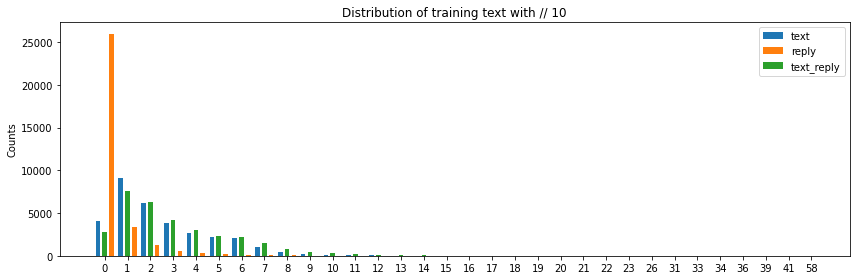

In [142]:
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

text_indices = np.arange(len(text_level))
reply_indices = np.arange(len(reply_level))
text_reply_indices = np.arange(len(text_reply_level))
# Plot results
fig, ax = plt.subplots(figsize=(12, 4))
width = 0.2
results_text = plt.bar(text_indices - 0.3, list(text_level.values()), width, label='text')
results_reply = plt.bar(reply_indices + 0.3, list(reply_level.values()), width, label='reply')
results_text_reply = plt.bar(text_reply_indices, list(text_reply_level.values()), width, label='text_reply')

plt.xticks(range(len(text_reply_level)), list(text_reply_level.keys()))
ax.set_ylabel('Counts')
ax.set_title('Distribution of training text with // 10')
# ax.set_xticks(x)
# ax.set_xticklabels(text_reply_indices)
ax.legend()

# autolabel(results_text)
# autolabel(results_reply)
# autolabel(results_text_reply)

fig.tight_layout()
plt.show()

In [11]:
# There isn't null value in training data
print(df.isnull().sum())
print(df_dev.isnull().sum())

idx           0
text          0
reply         0
categories    0
mp4           0
dtype: int64
idx      0
text     0
reply    0
dtype: int64


In [12]:
df.text.unique()

array(['we can all agree that any song by Niall Horan.',
       "Will you be installing #ScottyFromMarketing's new tracking app. \n\nPlease answer in the form of a gif.",
       'Growing up my mum would call me a Nigga despite her not being black. I would tell her to stop but she would only call me more racist slurs and hit me. I recently started dating a white boy and she’s being making more slurs and he joins in. What should i do? -anon',
       ..., 'Your @3rd is your future ex',
       'If tell you a duck can pull a truck, hook that mf up',
       'The only receipts in life are our memories weather you instill them in family or yourself make them count because they are non returnable. Love yall stay grinding.'],
      dtype=object)

In [106]:
torch.cuda.empty_cache()

## To-Do or Want-To-Do

- https://arxiv.org/pdf/1905.05583.pdf
    - [X] Try to count training and testing average length to modify max_seq_length
    - [ ] Head 128 + tail 382 when larger than 512 tokens get best results.
- [Exploratory Data Analysis](https://www.analyticsvidhya.com/blog/2020/04/beginners-guide-exploratory-data-analysis-text-data/?fbclid=IwAR07KpVViBMrZx5aboOMe2CPr4_QizPNoyW_Fdl6L1ZNN0_lhhGyl1KZxRg)
- [Blend models  10th](https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification/discussion/101630)
- [Blend models 2nd](https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification/discussion/100661)
- [Data cleaning](https://www.kaggle.com/christofhenkel/how-to-preprocessing-for-glove-part1-eda)

In [ ]:
# https://www.reddit.com/r/LanguageTechnology/comments/gnkeyl/covidtwitterbert_an_nlp_model_to_analyse_content/

Text(0.5, 1.0, 'Emotions Unnormalized')

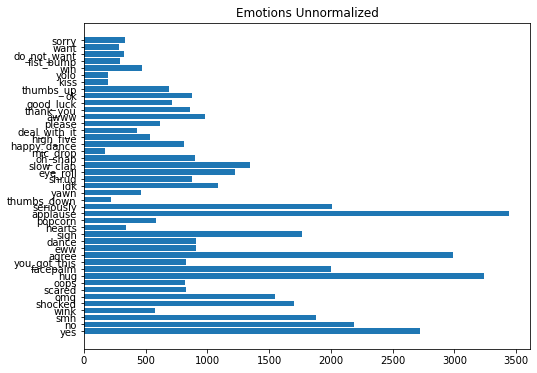

In [6]:
# Visualization of training classes
categories_dict = defaultdict(lambda: 0)
for i in range(len(df)):
    for each_category in df['categories'][i]:
        categories_dict[each_category] += 1
plt.figure(figsize=(8, 6))
plt.barh(list(categories_dict.keys()), categories_dict.values())
plt.title('Emotions Unnormalized')